In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from PIL import Image
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import zipfile

import torch.nn.functional as F
from rich.console import Console
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn
from rich.table import Table

import pandas as pd
from torch.cuda.amp import autocast, GradScaler


from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
# Install Git in case it's not available in your environment
!apt-get install git

# Clone the repository from GitHub
!git clone https://github.com/Samin1362/CSE499-MerakiNexus-AI_And_Defi.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Cloning into 'CSE499-MerakiNexus-AI_And_Defi'...
remote: Enumerating objects: 10162, done.
remote: Counting objects: 100% (383/383), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10162 (delta 375), reused 376 (delta 373), pack-reused 9779 (from 1)
Receiving objects: 100% (10162/10162), 2.03 GiB | 17.04 MiB/s, done.
Resolving deltas: 100% (1529/1529), done.
Updating files: 100% (14853/14853), done.


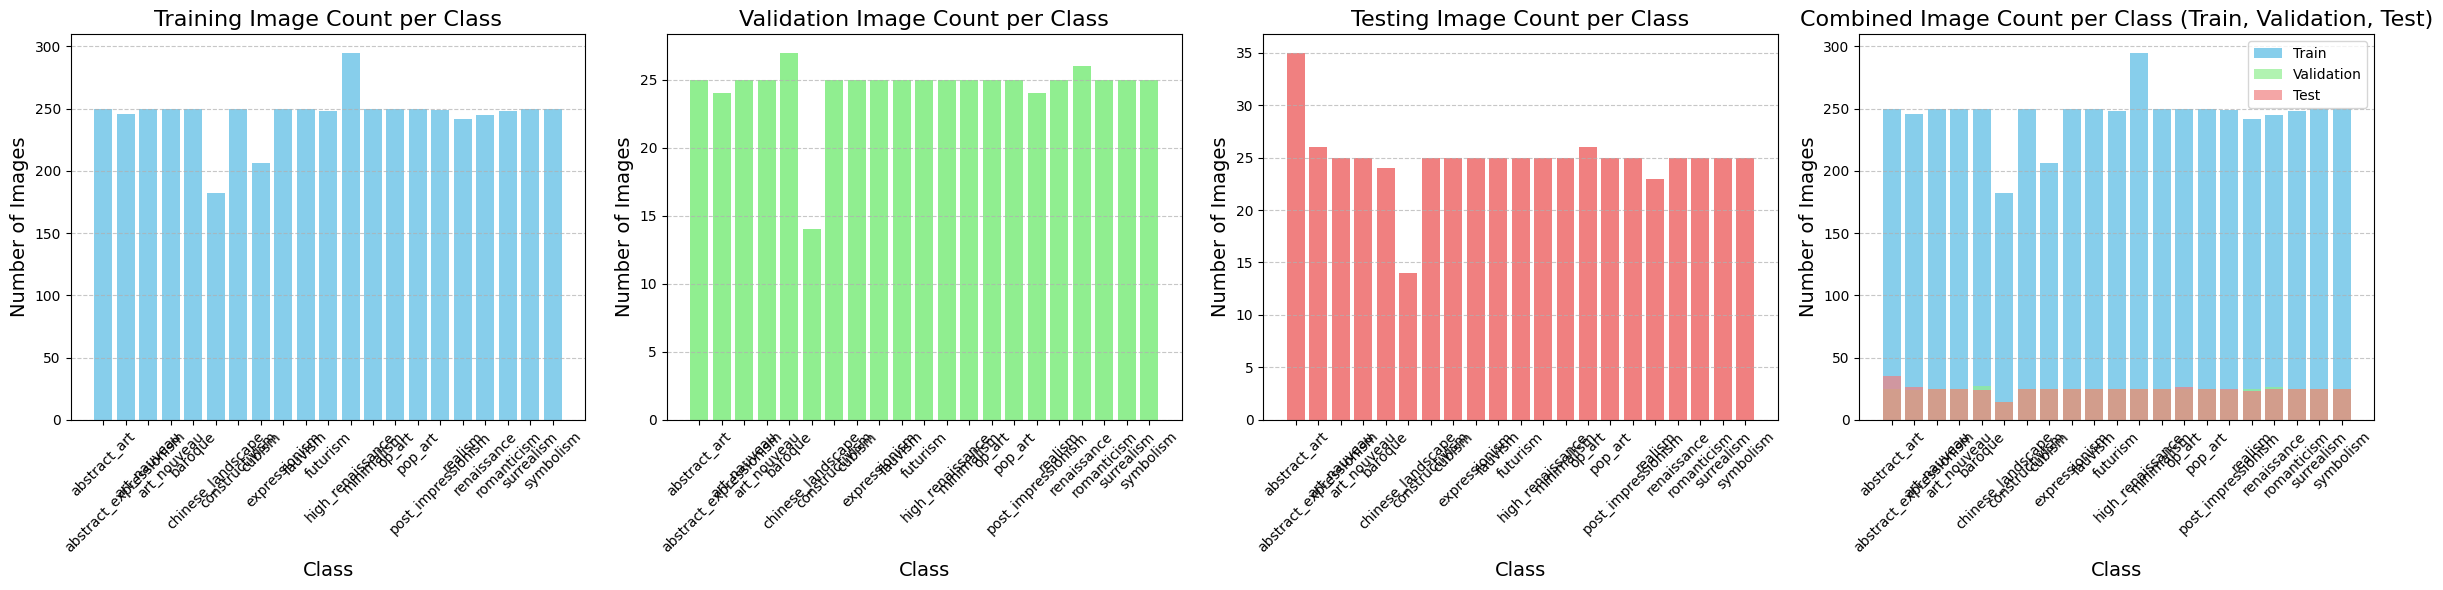

In [3]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets

# Define dataset path
dataset_path = "/content/CSE499-MerakiNexus-AI_And_Defi/art_classification_model/dataset"  # Modify with your dataset path

# Load the datasets
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train")
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val")
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test")

# Get class names and their corresponding folder paths
class_names = train_dataset.classes
train_image_counts = []
val_image_counts = []
test_image_counts = []

# Count the number of images in each class folder for all datasets
for class_name in class_names:
    # Count for training set
    train_class_folder = os.path.join(train_dataset.root, class_name)
    train_image_count = len(os.listdir(train_class_folder))  # Count files in each class folder
    train_image_counts.append(train_image_count)

    # Count for validation set
    val_class_folder = os.path.join(val_dataset.root, class_name)
    val_image_count = len(os.listdir(val_class_folder))  # Count files in each class folder
    val_image_counts.append(val_image_count)

    # Count for testing set
    test_class_folder = os.path.join(test_dataset.root, class_name)
    test_image_count = len(os.listdir(test_class_folder))  # Count files in each class folder
    test_image_counts.append(test_image_count)

# Plotting the class distribution for training, validation, and testing sets side by side
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Plot for training dataset
axes[0].bar(class_names, train_image_counts, color='skyblue')
axes[0].set_title('Training Image Count per Class', fontsize=16)
axes[0].set_xlabel('Class', fontsize=14)
axes[0].set_ylabel('Number of Images', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for validation dataset
axes[1].bar(class_names, val_image_counts, color='lightgreen')
axes[1].set_title('Validation Image Count per Class', fontsize=16)
axes[1].set_xlabel('Class', fontsize=14)
axes[1].set_ylabel('Number of Images', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for testing dataset
axes[2].bar(class_names, test_image_counts, color='lightcoral')
axes[2].set_title('Testing Image Count per Class', fontsize=16)
axes[2].set_xlabel('Class', fontsize=14)
axes[2].set_ylabel('Number of Images', fontsize=14)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for combined view (Training, Validation, and Testing)
axes[3].bar(class_names, train_image_counts, color='skyblue', label='Train')
axes[3].bar(class_names, val_image_counts, color='lightgreen', label='Validation', alpha=0.7)
axes[3].bar(class_names, test_image_counts, color='lightcoral', label='Test', alpha=0.7)
axes[3].set_title('Combined Image Count per Class (Train, Validation, Test)', fontsize=16)
axes[3].set_xlabel('Class', fontsize=14)
axes[3].set_ylabel('Number of Images', fontsize=14)
axes[3].tick_params(axis='x', rotation=45)
axes[3].legend()
axes[3].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]
Epoch 1/10 Training: 100%|██████████| 162/162 [01:29<00:00,  1.81it/s, loss=1.35]


Epoch 1 Loss: 1.5708 | Train Acc: 51.39% | Val Acc: 52.62%


Epoch 2/10 Training: 100%|██████████| 162/162 [01:32<00:00,  1.76it/s, loss=0.448]


Epoch 2 Loss: 0.6619 | Train Acc: 77.58% | Val Acc: 56.12%


Epoch 3/10 Training: 100%|██████████| 162/162 [01:30<00:00,  1.79it/s, loss=1.08]


Epoch 3 Loss: 0.3414 | Train Acc: 88.10% | Val Acc: 57.09%


Epoch 4/10 Training: 100%|██████████| 162/162 [01:30<00:00,  1.79it/s, loss=1.37]


Epoch 4 Loss: 0.2301 | Train Acc: 90.80% | Val Acc: 58.83%


Epoch 5/10 Training: 100%|██████████| 162/162 [01:30<00:00,  1.79it/s, loss=0.149]


Epoch 5 Loss: 0.1741 | Train Acc: 92.64% | Val Acc: 59.03%


Epoch 6/10 Training: 100%|██████████| 162/162 [01:29<00:00,  1.80it/s, loss=0.259]


Epoch 6 Loss: 0.1396 | Train Acc: 92.99% | Val Acc: 61.17%


Epoch 7/10 Training: 100%|██████████| 162/162 [01:29<00:00,  1.80it/s, loss=0.38]


Epoch 7 Loss: 0.1385 | Train Acc: 93.51% | Val Acc: 57.48%


Epoch 8/10 Training: 100%|██████████| 162/162 [01:29<00:00,  1.80it/s, loss=0.218]


Epoch 8 Loss: 0.1699 | Train Acc: 91.77% | Val Acc: 55.92%


Epoch 9/10 Training: 100%|██████████| 162/162 [01:30<00:00,  1.80it/s, loss=0.411]


Epoch 9 Loss: 0.1640 | Train Acc: 92.60% | Val Acc: 58.64%


Epoch 10/10 Training: 100%|██████████| 162/162 [01:29<00:00,  1.81it/s, loss=0.476]


Epoch 10 Loss: 0.1664 | Train Acc: 91.94% | Val Acc: 60.97%

Total Training Time: 949.94s (15.83min)


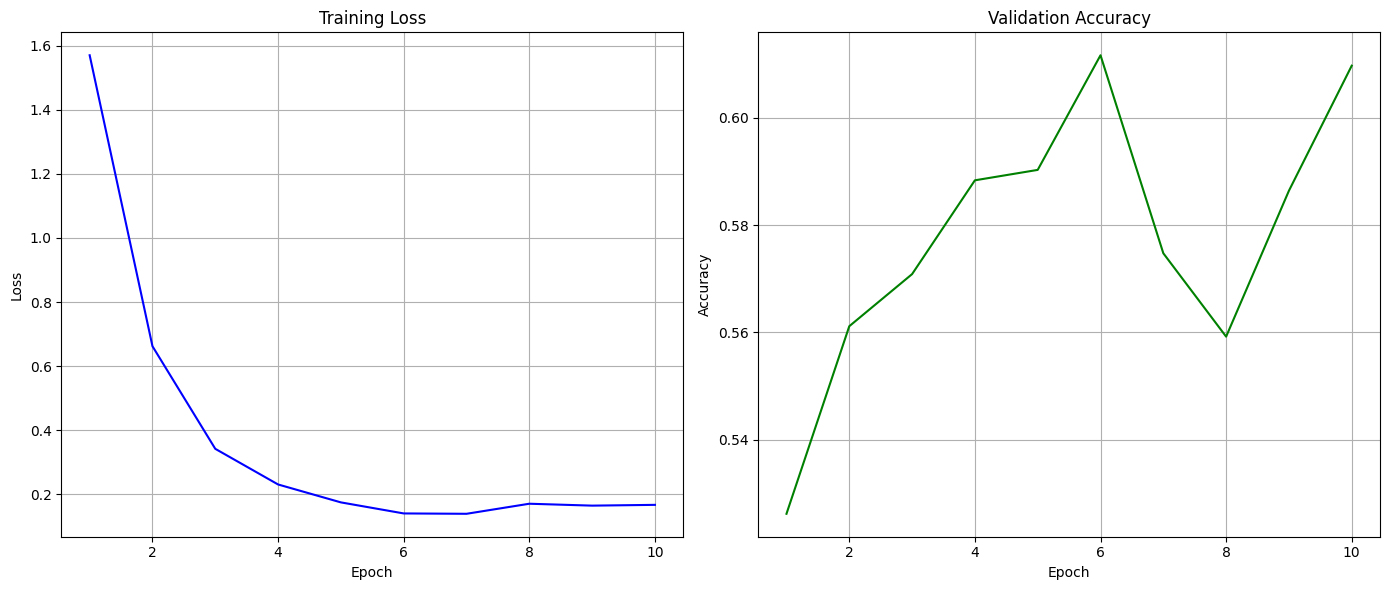


Test Accuracy: 61.19%

Classification Report:

                        precision    recall  f1-score   support

          abstract_art       0.54      0.54      0.54        35
abstract_expressionism       0.59      0.62      0.60        26
           art_nauveau       0.40      0.16      0.23        25
           art_nouveau       0.29      0.16      0.21        25
               baroque       0.56      0.75      0.64        24
     chinese_landscape       0.70      1.00      0.82        14
        constructivism       0.53      0.72      0.61        25
                cubism       0.80      0.48      0.60        25
         expressionism       0.88      0.60      0.71        25
               fauvism       0.59      0.40      0.48        25
              futurism       0.59      0.64      0.62        25
      high_renaissance       0.50      0.64      0.56        25
            minimalism       0.88      0.84      0.86        25
                op_art       0.62      0.69      0.65  

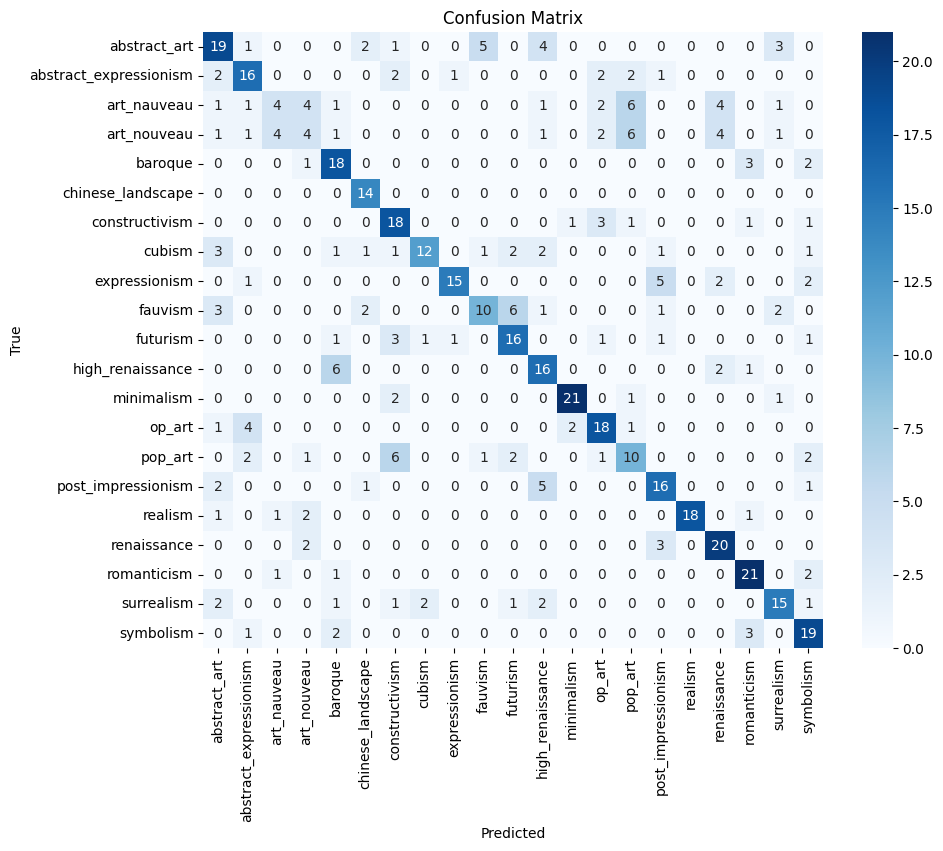

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define custom dataset
class CustomArtworkDataset(datasets.ImageFolder):
    def __getitem__(self, idx):
        path, class_idx = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, class_idx  # Return label as integer

# Define model
class ArtworkClassificationModel(nn.Module):
    def __init__(self, num_classes=11):
        super(ArtworkClassificationModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Paths
dataset_path = "/content/CSE499-MerakiNexus-AI_And_Defi/art_classification_model/dataset"
train_data = CustomArtworkDataset(root=f"{dataset_path}/train", transform=transform)
val_data = CustomArtworkDataset(root=f"{dataset_path}/val", transform=transform)
test_data = CustomArtworkDataset(root=f"{dataset_path}/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Initialize model
model = ArtworkClassificationModel(num_classes=len(train_data.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
num_epochs = 10
train_losses = []
val_accuracies = []
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            tepoch.set_postfix(loss=loss.item())

    train_accuracy = correct / total
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracy*100:.2f}% | Val Acc: {val_accuracy*100:.2f}%")

# Training time
total_time = time.time() - start_time
print(f"\nTotal Training Time: {total_time:.2f}s ({total_time/60:.2f}min)")

# Plot Loss and Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, color='blue')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# =======================
# Evaluation on Test Set
# =======================
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy & Report
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%\n")
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_data.classes, yticklabels=train_data.classes, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 101MB/s]
Epoch 1/25 Training: 100%|██████████| 162/162 [01:07<00:00,  2.40it/s, loss=2.37]


Epoch 1 Loss: 2.4972 | Train Acc: 32.45% | Val Acc: 43.50%


Epoch 2/25 Training: 100%|██████████| 162/162 [01:05<00:00,  2.49it/s, loss=0.975]


Epoch 2 Loss: 1.4379 | Train Acc: 58.59% | Val Acc: 53.20%


Epoch 3/25 Training: 100%|██████████| 162/162 [01:02<00:00,  2.58it/s, loss=0.784]


Epoch 3 Loss: 0.9462 | Train Acc: 70.72% | Val Acc: 57.48%


Epoch 4/25 Training: 100%|██████████| 162/162 [01:03<00:00,  2.54it/s, loss=1.87]


Epoch 4 Loss: 0.6558 | Train Acc: 78.49% | Val Acc: 58.25%


Epoch 5/25 Training: 100%|██████████| 162/162 [01:03<00:00,  2.55it/s, loss=1.26]


Epoch 5 Loss: 0.4626 | Train Acc: 85.22% | Val Acc: 61.55%


Epoch 6/25 Training: 100%|██████████| 162/162 [01:03<00:00,  2.54it/s, loss=0.548]


Epoch 6 Loss: 0.3432 | Train Acc: 87.60% | Val Acc: 59.61%


Epoch 7/25 Training: 100%|██████████| 162/162 [01:03<00:00,  2.55it/s, loss=1.08]


Epoch 7 Loss: 0.2680 | Train Acc: 89.30% | Val Acc: 61.75%


Epoch 8/25 Training: 100%|██████████| 162/162 [01:02<00:00,  2.58it/s, loss=0.621]


Epoch 8 Loss: 0.2191 | Train Acc: 91.11% | Val Acc: 62.52%


Epoch 9/25 Training: 100%|██████████| 162/162 [01:04<00:00,  2.52it/s, loss=0.665]


Epoch 9 Loss: 0.1944 | Train Acc: 92.00% | Val Acc: 61.55%


Epoch 10/25 Training: 100%|██████████| 162/162 [01:03<00:00,  2.55it/s, loss=0.487]


Epoch 10 Loss: 0.1850 | Train Acc: 91.86% | Val Acc: 61.94%


Epoch 11/25 Training: 100%|██████████| 162/162 [01:04<00:00,  2.51it/s, loss=0.321]


Epoch 11 Loss: 0.1551 | Train Acc: 92.70% | Val Acc: 63.50%


Epoch 12/25 Training: 100%|██████████| 162/162 [01:02<00:00,  2.57it/s, loss=0.556]


Epoch 12 Loss: 0.1374 | Train Acc: 93.18% | Val Acc: 60.78%


Epoch 13/25 Training: 100%|██████████| 162/162 [01:02<00:00,  2.58it/s, loss=0.331]


Epoch 13 Loss: 0.1394 | Train Acc: 93.45% | Val Acc: 59.22%


Epoch 14/25 Training: 100%|██████████| 162/162 [01:03<00:00,  2.56it/s, loss=0.677]


Epoch 14 Loss: 0.1309 | Train Acc: 93.02% | Val Acc: 62.33%


Epoch 15/25 Training: 100%|██████████| 162/162 [01:03<00:00,  2.54it/s, loss=0.23]


Epoch 15 Loss: 0.1247 | Train Acc: 93.61% | Val Acc: 62.14%


Epoch 16/25 Training: 100%|██████████| 162/162 [01:05<00:00,  2.47it/s, loss=0.0329]


Epoch 16 Loss: 0.1307 | Train Acc: 93.30% | Val Acc: 61.94%


Epoch 17/25 Training: 100%|██████████| 162/162 [01:04<00:00,  2.49it/s, loss=0.496]


Epoch 17 Loss: 0.1241 | Train Acc: 93.59% | Val Acc: 64.08%


Epoch 18/25 Training: 100%|██████████| 162/162 [01:04<00:00,  2.50it/s, loss=0.338]


Epoch 18 Loss: 0.1209 | Train Acc: 92.99% | Val Acc: 64.47%


Epoch 19/25 Training: 100%|██████████| 162/162 [01:05<00:00,  2.48it/s, loss=0.0407]


Epoch 19 Loss: 0.1140 | Train Acc: 93.70% | Val Acc: 61.75%


Epoch 20/25 Training: 100%|██████████| 162/162 [01:04<00:00,  2.52it/s, loss=0.203]


Epoch 20 Loss: 0.1090 | Train Acc: 94.01% | Val Acc: 63.88%


Epoch 21/25 Training: 100%|██████████| 162/162 [01:04<00:00,  2.53it/s, loss=0.164]


Epoch 21 Loss: 0.1148 | Train Acc: 93.10% | Val Acc: 61.94%


Epoch 22/25 Training: 100%|██████████| 162/162 [01:03<00:00,  2.53it/s, loss=0.341]


Epoch 22 Loss: 0.1094 | Train Acc: 93.82% | Val Acc: 64.27%


Epoch 23/25 Training: 100%|██████████| 162/162 [01:03<00:00,  2.55it/s, loss=0.276]


Epoch 23 Loss: 0.1107 | Train Acc: 93.57% | Val Acc: 63.69%


Epoch 24/25 Training: 100%|██████████| 162/162 [01:03<00:00,  2.56it/s, loss=0.171]


Epoch 24 Loss: 0.0979 | Train Acc: 93.86% | Val Acc: 64.66%


Epoch 25/25 Training: 100%|██████████| 162/162 [01:03<00:00,  2.54it/s, loss=0.0464]


Epoch 25 Loss: 0.1050 | Train Acc: 93.64% | Val Acc: 64.47%

Total Training Time: 1710.80s (28.51min)


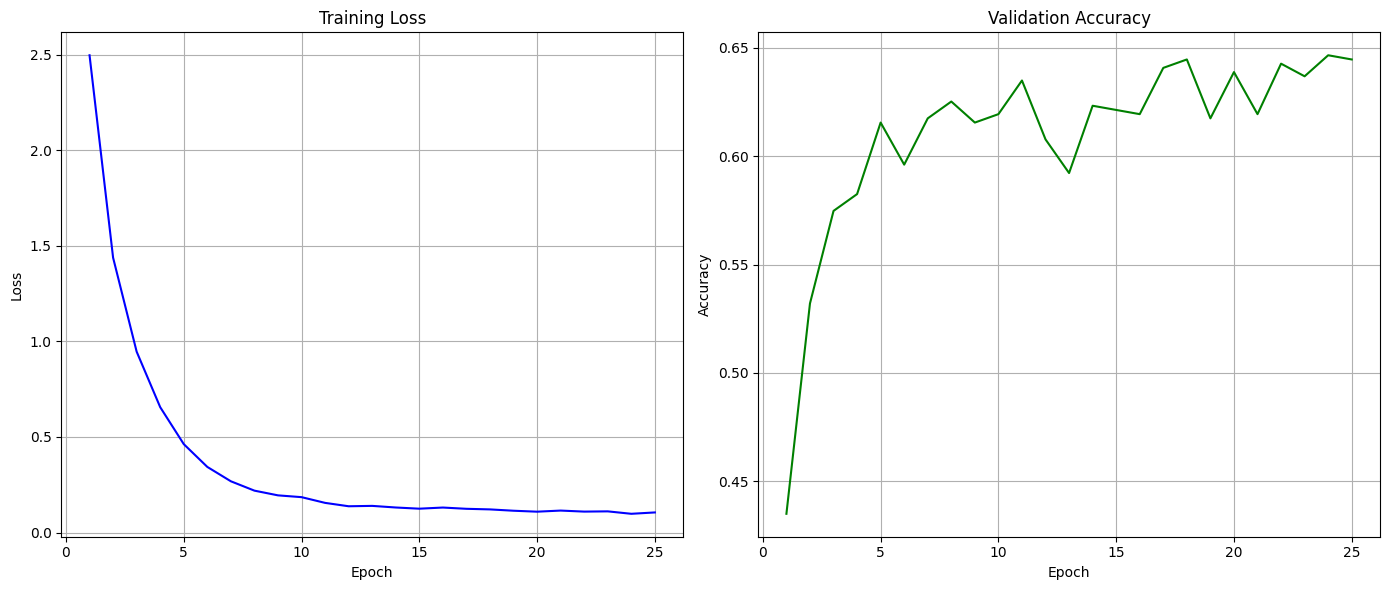


Test Accuracy: 63.29%

Classification Report:

                        precision    recall  f1-score   support

          abstract_art       0.66      0.54      0.59        35
abstract_expressionism       0.60      0.69      0.64        26
           art_nauveau       0.47      0.32      0.38        25
           art_nouveau       0.50      0.08      0.14        25
               baroque       0.70      0.96      0.81        24
     chinese_landscape       0.78      1.00      0.88        14
        constructivism       0.50      0.44      0.47        25
                cubism       0.65      0.52      0.58        25
         expressionism       0.68      0.68      0.68        25
               fauvism       0.43      0.40      0.42        25
              futurism       0.40      0.76      0.53        25
      high_renaissance       0.88      0.60      0.71        25
            minimalism       0.76      0.88      0.81        25
                op_art       0.67      0.69      0.68  

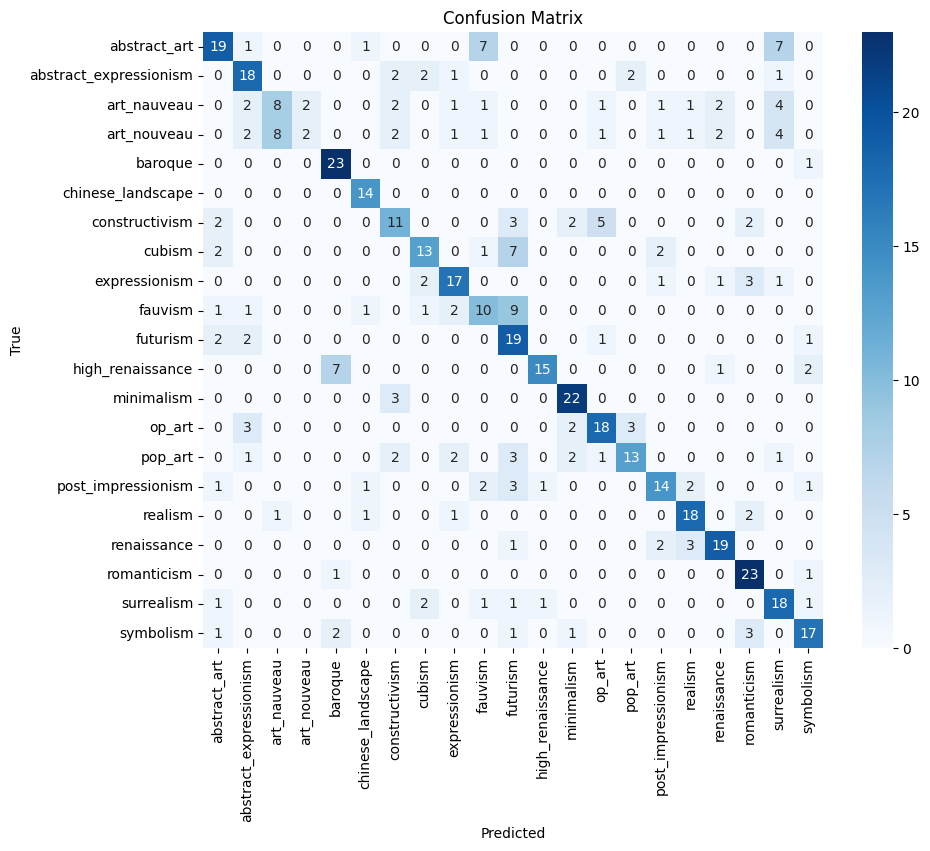

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom dataset
class CustomArtworkDataset(datasets.ImageFolder):
    def __getitem__(self, idx):
        path, class_idx = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, class_idx

# EfficientNet-based model
class ArtworkClassificationModel(nn.Module):
    def __init__(self, num_classes=11):
        super(ArtworkClassificationModel, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet prefers 224x224 input for b0
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset paths
dataset_path = "/content/CSE499-MerakiNexus-AI_And_Defi/art_classification_model/dataset"
train_data = CustomArtworkDataset(root=f"{dataset_path}/train", transform=transform)
val_data = CustomArtworkDataset(root=f"{dataset_path}/val", transform=transform)
test_data = CustomArtworkDataset(root=f"{dataset_path}/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Model, Loss, Optimizer
model = ArtworkClassificationModel(num_classes=len(train_data.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
num_epochs = 25
train_losses = []
val_accuracies = []
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            tepoch.set_postfix(loss=loss.item())

    train_accuracy = correct / total
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1} Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracy*100:.2f}% | Val Acc: {val_accuracy*100:.2f}%")

# Training time
total_time = time.time() - start_time
print(f"\nTotal Training Time: {total_time:.2f}s ({total_time/60:.2f}min)")

# Plot Loss and Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, color='blue')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation on Test Set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [5]:
scripted_model = torch.jit.script(model)  # Convert to TorchScript

# Save the TorchScript model to a file
torch.jit.save(scripted_model, "/content/artwork_classification_model_efficientNet.pth");

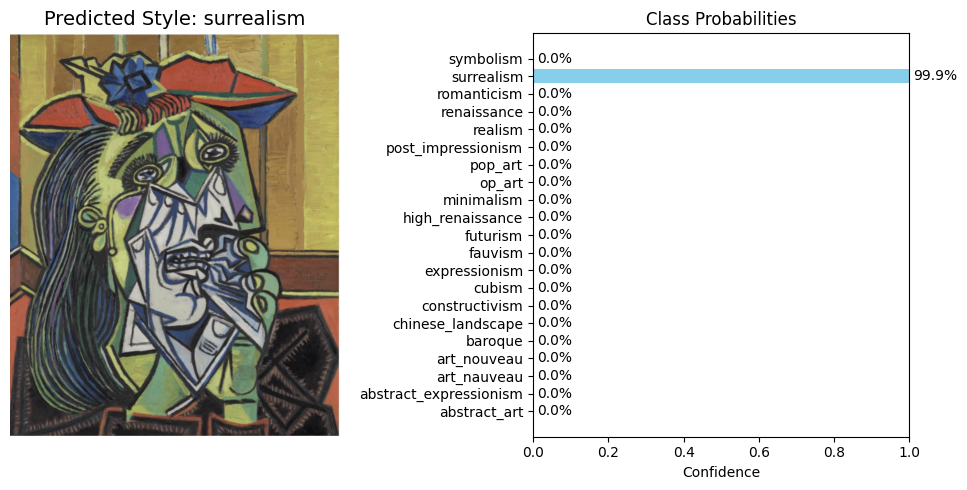

In [7]:
scripted_model = torch.jit.load("/content/artwork_classification_model_efficientNet.pth")
scripted_model.eval()

# --- Visualize prediction for a single image ---
def predict_single_image(image_path, model, transform, class_names):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Set model to evaluation mode and make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class_idx = output.argmax(dim=1).item()
        predicted_class = class_names[predicted_class_idx]
        probabilities = torch.nn.functional.softmax(output, dim=1).cpu().numpy()[0]

    # Visualization
    plt.figure(figsize=(10, 5))

    # Show the image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Predicted Style: {predicted_class}", fontsize=14)
    plt.axis("off")

    # Show prediction confidence for each class
    plt.subplot(1, 2, 2)
    bars = plt.barh(class_names, probabilities, color='skyblue')
    plt.xlabel("Confidence")
    plt.title("Class Probabilities")
    plt.xlim([0, 1])
    for bar in bars:
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                 f"{bar.get_width()*100:.1f}%", va='center')
    plt.tight_layout()
    plt.show()

# Example usage
test_image_path = "1.png"  # change this to your test image
predict_single_image(test_image_path, scripted_model, transform, train_data.classes)
